In [ ]:
import torch
torch.rand(1).to('cuda') #initialize cuda context (might take a while)

from net import PrunedCifarNet
import torch
from typing import Dict, List
import numpy as np

import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
tf = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testloader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('data/', train=False, download=True, transform=tf), shuffle=False, batch_size=32)
trainloader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('data/', train=True, download=True, transform=tf), shuffle=True, batch_size=32)

In [ ]:
def l1_structured_pruning(state_dict: Dict, prune_ratio: float) -> Dict:
    state_dict = copy.deepcopy(state_dict)
    
    for key, tensor in state_dict.items():
        if 'conv' in key and 'weight' in key and 'conv1' not in key and 'conv2' not in key:
            l1_norms = tensor.abs().sum(dim=(1, 2, 3))
            _, sorted_indexes = torch.sort(l1_norms, descending=False)
            k = int(len(sorted_indexes) * prune_ratio) # maybe max w 1
            to_prune = sorted_indexes[:k]
            tensor[to_prune] = 0
        if 'conv' in key and 'bias' in key and 'conv1' not in key and 'conv2' not in key:
            tensor[to_prune] = 0
    return state_dict

100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


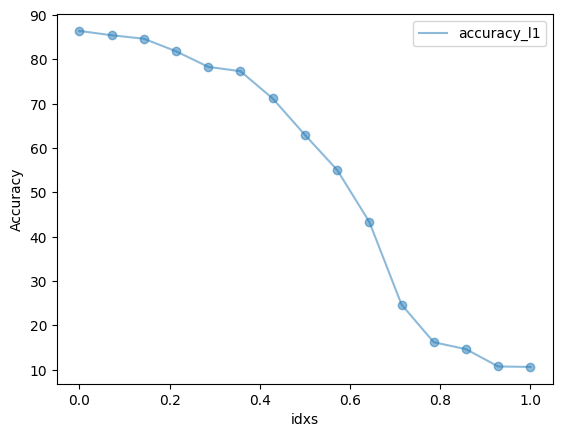

In [ ]:
import tqdm
import copy

from utils import net_acc, net_time, net_macs, plot

ratios = np.linspace(0, 0.8, 15)

state_dict = torch.load('state_dict__cifarnet.pt')
accuracy_l1, idxs = [], []
for idx, ratio in tqdm.tqdm(enumerate(ratios), total=len(ratios)):
    state_dict = l1_structured_pruning(state_dict, ratio)
    accuracy_l1.append(net_acc(PrunedCifarNet, state_dict, testloader, batches=32, device='cuda'))
    idxs.append(idx)
plot([(idxs, accuracy_l1, 'accuracy_l1')], xlabel='idxs', save_path='accuracy_l1.png')

In [ ]:
def densify_state_dict(state_dict: Dict) -> Dict:
    state_dict = copy.deepcopy(state_dict)
    new_state_dict = {}
    prev_active_idxs = None

    for key, tensor in state_dict.items():
        if 'weight' not in key:
            continue

        bias_key = key.replace('weight', 'bias')
        is_conv = tensor.dim() == 4
        is_fc = tensor.dim() == 2
        
        if is_conv:
            l1_norms = tensor.abs().sum(dim=(1, 2, 3))
            active_out = (l1_norms != 0).nonzero(as_tuple=True)[0]
            tensor = tensor[active_out, :, :, :]

            # prune input channels if previous layer was pruned
            if prev_active_idxs is not None:
                tensor = tensor[:, prev_active_idxs, :, :]

            new_state_dict[key] = tensor
            new_state_dict[bias_key] = state_dict[bias_key][active_out]

            prev_active_idxs = active_out

        elif is_fc:
            size = 2 * 2 
            if prev_active_idxs is not None:
                
                prev_active_idxs.to('cpu')
                fc_active = prev_active_idxs.unsqueeze(1) * size + torch.arange(size)
                fc_active = fc_active.flatten()

                tensor = tensor[:, fc_active]
                # print(tensor.shape)

            new_state_dict[key] = tensor
            new_state_dict[bias_key] = state_dict[bias_key]
            
    return new_state_dict

100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


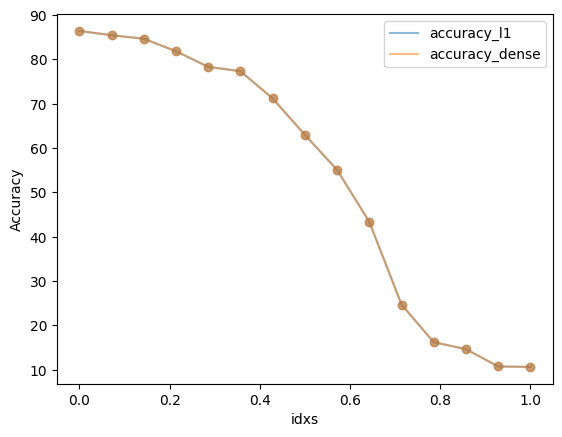

In [ ]:
state_dict = torch.load('state_dict__cifarnet.pt')
accuracy_dense = []
for idx, ratio in tqdm.tqdm(enumerate(ratios), total=len(ratios)):
    state_dict = l1_structured_pruning(state_dict, ratio)
    sd = densify_state_dict(state_dict)
    accuracy_dense.append(net_acc(PrunedCifarNet, sd, testloader, batches=32, device='cuda'))
plot([(idxs, accuracy_l1, 'accuracy_l1'), (idxs, accuracy_dense, 'accuracy_dense')], xlabel='idxs', save_path='accuracy_l1.png')

In [ ]:
def train(model_class: torch.nn.Module, state_dict: Dict,
          trainloader: torch.utils.data.DataLoader, batches: int=64, device: str='cpu'):

    lr = 0.01

    torch_device = torch.device(device)

    model = model_class()
    model.load_state_dict(state_dict)
    model.to(torch_device)

    model.train()
    
    # For all conv layers we disable the calculation of gradients in the backwards step
    for key, param in model.named_parameters():
        if any(x in key for x in ['1', '2', '3', '4', '5', '6']):
            param.requires_grad = False
    # The optimizer gets only the parameters that require gradient calculation
    optimizer = torch.optim.SGD(filter(lambda x: x.requires_grad, model.parameters()), lr=lr)
    
    # Loss function
    loss_f = torch.nn.CrossEntropyLoss()
    

    for idx, (inputs, targets) in enumerate(trainloader):
        
        if idx >= batches:
            break  # stop after the specified number of batches

        inputs, targets = inputs.to(torch_device), targets.to(torch_device)

        outputs = model(inputs)
        loss = loss_f(outputs, targets)
        optimizer.zero_grad() # The new gradients will be added to old ones from previous batches!
        loss.backward()
        optimizer.step()
    model.to('cpu')

    return model.state_dict()

100%|██████████| 26/26 [00:30<00:00,  1.19s/it]


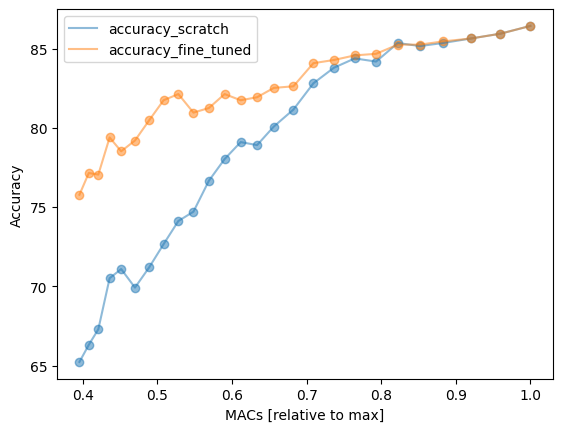

In [ ]:
# define ratios
ratios = [0.0] + [0.025 for _ in range(25)]
state_dict = torch.load('state_dict__cifarnet.pt')
accuracy_from_scratch, accuracy_fine_tuned, macs = [], [], []
for ratio in tqdm.tqdm(ratios):
    
    # Setting Filters to zero
    state_dict = l1_structured_pruning(state_dict, ratio)
    
    # Densifying the state dict
    state_dict = densify_state_dict(copy.deepcopy(state_dict))
    
    # Accuracy calculation
    accuracy_from_scratch.append(net_acc(PrunedCifarNet, state_dict, testloader, batches=32, device='cuda'))

#We now do the same with training for comparions (this might take a while)
state_dict = torch.load('state_dict__cifarnet.pt')
for ratio in tqdm.tqdm(ratios):
    state_dict = l1_structured_pruning(state_dict, ratio)
    state_dict = densify_state_dict(copy.deepcopy(state_dict))
    
    #We fine tune the network by training with 150 batches
    state_dict = train(PrunedCifarNet, state_dict, trainloader, batches=32, device='cuda')
    accuracy_fine_tuned.append(net_acc(PrunedCifarNet, state_dict, testloader, batches=32, device='cuda'))
    macs.append(net_macs(PrunedCifarNet, state_dict))
    
    
plot([(macs, accuracy_from_scratch, 'accuracy_scratch'),
      (macs, accuracy_fine_tuned, 'accuracy_fine_tuned')],
      xlabel='MACs [relative to max]', save_path='accuracy_macs.png')